SRAG 2021 e 2022 - Banco de Dados de Síndrome Respiratória Aguda Grave - incluindo dados da COVID-19

Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import io
import requests
from sklearn.feature_selection import chi2
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings

Datasets

In [5]:
original_data_2022 = pd.read_csv('INFLUD22-26-09-2022.csv', delimiter=';', usecols = ['CS_SEXO','CS_RACA','SG_UF_NOT','UTI','RAIOX_RES','CS_ESCOL_N','CS_GESTANT','PUERPERA','CLASSI_FIN','VACINA_COV','CRITERIO','CARDIOPATI','RENAL','ASMA','DIABETES','HEMATOLOGI','SIND_DOWN','HEPATICA','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','OBESIDADE','OUT_MORBI','EVOLUCAO','DT_COLETA','NU_IDADE_N','FEBRE','TOSSE','GARGANTA','DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO','DOR_ABD','FADIGA','PERD_OLFT','PERD_PALA'])
original_data_2021 = pd.read_csv('INFLUD21-2021.csv', delimiter=';', usecols = ['CS_SEXO','CS_RACA','SG_UF_NOT','UTI','RAIOX_RES','CS_ESCOL_N','CS_GESTANT','PUERPERA','CLASSI_FIN','VACINA_COV','CRITERIO','CARDIOPATI','RENAL','ASMA','DIABETES','HEMATOLOGI','SIND_DOWN','HEPATICA','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','OBESIDADE','OUT_MORBI','EVOLUCAO','DT_COLETA','NU_IDADE_N','FEBRE','TOSSE','GARGANTA','DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO','DOR_ABD','FADIGA','PERD_OLFT','PERD_PALA'])

In [7]:
data2022 = original_data_2022.copy(deep=True)
data2021 = original_data_2021.copy(deep=True)

Dataclean - 2021

In [11]:
#replace NAN values
data2021['CLASSI_FIN'].fillna(4, inplace = True)
data2021['CRITERIO'].fillna(0, inplace=True)
data2021['CS_GESTANT'].replace([0], 9, inplace=True) # Replace NANs with ignored values
data2021.fillna(9, inplace = True)

# Convert float columns to int
float_columns = data2021.select_dtypes(include='float').columns
data2021[float_columns] = data2021[float_columns].astype(int)

# Delimit dataset for pregnant and postpartum women
data2021['GRAVIDEZ'] = np.where(data2021['CS_GESTANT'].isin([1, 2, 3, 4]), data2021['CS_GESTANT'], 0)
data2021.loc[data2021['PUERPERA'] == 1, 'GRAVIDEZ'] = 5 # Defining that puerperal women receive 5 in the dataset

# Delimit dataset for confirmed COVID cases
data2021['COVID_LABORATORIAL'] = 0
data2021.loc[data2021['CLASSI_FIN'] == 5, 'COVID_LABORATORIAL'] = 5
data2021.loc[data2021['CRITERIO'] == 1, 'COVID_LABORATORIAL'] = 1

# Filter the dataset
data_temp2021 = data2021.loc[(data2021['GRAVIDEZ'] != 0) & (data2021['CLASSI_FIN'] == 5) & (data2021['CRITERIO'] == 1)].copy()
data_temp2021.reset_index(inplace=True, drop=True)

Dataclean - 2022

In [19]:
# Fill missing values
data2022['CLASSI_FIN'].fillna(4, inplace=True)
data2022['CRITERIO'].fillna(0, inplace=True)
data2022['CS_GESTANT'].replace([0], 9, inplace=True)
data2022.fillna(9, inplace=True)

# Convert float columns to int
float_columns_2022 = data2022.select_dtypes(include='float').columns
data2022[float_columns_2022] = data2022[float_columns_2022].astype(int)

# Delimit dataset for pregnant and postpartum women
data2022['GRAVIDEZ'] = np.where(data2022['CS_GESTANT'].isin([1, 2, 3, 4]), data2022['CS_GESTANT'], 0)
data2022.loc[data2022['PUERPERA'] == 1, 'GRAVIDEZ'] = 5

# Delimit dataset for confirmed COVID cases
data2022['COVID_LABORATORIAL'] = 0
data2022.loc[data2022['CLASSI_FIN'] == 5, 'COVID_LABORATORIAL'] = 5
data2022.loc[data2022['CRITERIO'] == 1, 'COVID_LABORATORIAL'] = 1

# Filter the dataset
data_temp2022 = data2022.loc[(data2022['GRAVIDEZ'] != 0) & (data2022['CLASSI_FIN'] == 5) & (data2022['CRITERIO'] == 1)].copy()
data_temp2022.reset_index(inplace=True, drop=True)

Concatenating the two DataFrames 

In [165]:
data_pre = pd.concat([data_temp2021,data_temp2022],ignore_index=True)
df_concat = data_pre.drop_duplicates(keep=False)
df_concat.reset_index(inplace = True, drop = True)
df_concat.loc[:, 'DT_COLETA'] = pd.to_datetime(df_concat['DT_COLETA'], format='%d/%m/%Y', errors='coerce')
df_concat = df_concat.dropna(subset=['DT_COLETA']).reset_index(drop=True) # remove rows (> 500) where the 'DT_COLETA' column has NaN values

C:\Users\User\AppData\Local\Temp\ipykernel_11456\2773814424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat.loc[:, 'DT_COLETA'] = pd.to_datetime(df_concat['DT_COLETA'], format='%d/%m/%Y', errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_11456\2773814424.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_concat.loc[:, 'DT_COLETA'] = pd.to_datetime(df_concat['DT_COLETA'], format='%d/%m/%Y', errors='coerce')


We considered the VOCs predominance period for:

Gama P.1 (March 2021 to Jul 2021);

Delta AY (Sept 2021 November 2021);

Omicrom BA (January 2022 aug 2022).



In [166]:
# Creating datasets that separate the variants
selecao_gama = (df_concat['DT_COLETA'] >= '2021-03-01') & (df_concat['DT_COLETA'] <= '2021-07-30')
selecao_delta= (df_concat['DT_COLETA'] >= '2021-09-01') & (df_concat['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df_concat['DT_COLETA'] >= '2022-01-01') & (df_concat['DT_COLETA'] <= '2022-08-30')

df_selection_gamma = df_concat[selecao_gama]
df_selection_delta = df_concat[selecao_delta]
df_selection_omicron = df_concat[selecao_omicrom]

print("Gamma sample: ", df_selection_gamma.shape)
print("Delta sample: ", df_selection_delta.shape)
print("Omicron sample: ", df_selection_omicron.shape)
print("Number of pregnant women: ", df_concat['GRAVIDEZ'].value_counts()[1] + df_concat['GRAVIDEZ'].value_counts()[2] + df_concat['GRAVIDEZ'].value_counts()[3] + df_concat['GRAVIDEZ'].value_counts()[4])
print("Number of postpartum women: ", df_concat['GRAVIDEZ'].value_counts()[5])
print()

# Creating a COVID variant variable
df_concat['VARIANTE_COVID'] = 0
df_concat.loc[selection_gamma, 'VARIANTE_COVID'] = 1
df_concat.loc[selection_delta, 'VARIANTE_COVID'] = 2
df_concat.loc[selection_omicron, 'VARIANTE_COVID'] = 3

df_concat = df_concat.loc[(df_concat['VARIANTE_COVID'] != 0)]
df_concat.reset_index(inplace=True, drop=True)
print("Final size of the dataframe: ", df_concat.shape)
print()

Gamma sample:  (8117, 40)
Delta sample:  (695, 40)
Omicron sample:  (3909, 40)
Number of pregnant women:  11148
Number of postpartum women:  3705

Final size of the dataframe:  (12721, 41)



Merge datasets to obtain region names

In [167]:
# Data URL (CSV file)
url = 'https://raw.githubusercontent.com/chandez/Estados-Cidades-IBGE/master/csv/estados.csv'

# Execute protocol to request data from a CSV file on the internet.
s = requests.get(url).content
file_name = io.StringIO(s.decode('utf-8'))
dm = pd.read_csv(url)

# Extracting the first 'table'
dm['Regiao_nome'] = dm['Regiao'] * 0
region_list = dm['Regiao'].tolist()

# Creating a mapping dictionary for region names
region_mapping = {1: 'North', 2: 'Northeast', 3: 'Southeast', 4: 'South', 5: 'Midwest'}

# Mapping the region names based on the 'Region' column
dm['Regiao_nome'] = dm['Regiao'].map(region_mapping)

dm = dm.drop(columns=['Nome', 'Id', 'CodigoUf'])
dm = dm.rename(columns={'Uf': 'SG_UF_NOT'})
df = df_concat.merge(dm, how='left', on='SG_UF_NOT')

lista_regiao_nome = df['Regiao_nome'].tolist()

**Table 1: Sociodemographic and obstetrical characteristics of women with  laboratory confirmed SARS-CoV-2 infection.**

Relationship between covid variant and age

C:\Users\User\AppData\Local\Temp\ipykernel_11456\3140467252.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in range(len(df[selecao_gama])):
C:\Users\User\AppData\Local\Temp\ipykernel_11456\3140467252.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in range(len(df[selecao_delta])):
C:\Users\User\AppData\Local\Temp\ipykernel_11456\3140467252.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in range(len(df[selecao_omicrom])):



------------- p value  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.48643000943716297

Failed to reject the null hypothesis.

Graph showing the relationship between covid variant and age group : 



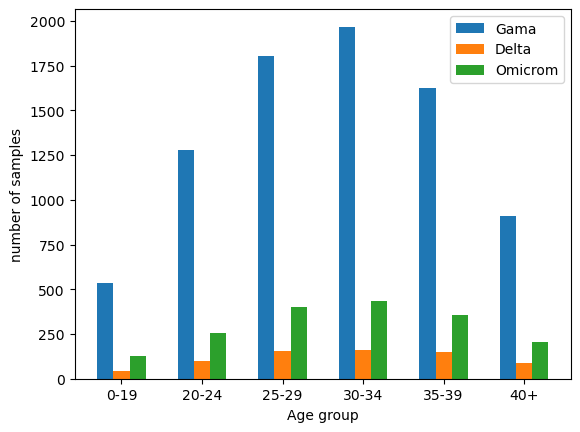


------------- Total value and percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N,Total
0-19,534 (6.58),45 (6.47),129 (7.22),708
20-24,1279 (15.76),98 (14.1),258 (14.45),1635
25-29,1805 (22.24),155 (22.3),399 (22.34),2359
30-34,1967 (24.23),158 (22.73),436 (24.41),2561
35-39,1625 (20.02),150 (21.58),358 (20.04),2133
40+,907 (11.17),89 (12.81),206 (11.53),1202


In [125]:
lista_idade=df['NU_IDADE_N'].tolist()
lista_gama = df.loc[selecao_gama, 'DT_COLETA'].tolist()
lista_delta = df.loc[selecao_delta, 'DT_COLETA'].tolist()
lista_omicrom = df.loc[selecao_omicrom, 'DT_COLETA'].tolist()

resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # setting gama variant to 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # setting delta variant to 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # setting omicrom variant to 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_idade[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_idade[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_idade[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom
Faixa_etaria = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+']

lista_1 = []
for i in range(len(resultados)):
    if 0 <= resultados[i][0] <= 19:
        lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)):
    if 20 <= resultados[i][0] <= 24:
        lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)):
    if 25 <= resultados[i][0] <= 29:
        lista_3.append(resultados[i][1])

lista_4 = []
for i in range(len(resultados)):
    if 30 <= resultados[i][0] <= 34:
        lista_4.append(resultados[i][1])

lista_5 = []
for i in range(len(resultados)):
    if 35 <= resultados[i][0] <= 39:
        lista_5.append(resultados[i][1])

lista_6 = []
for i in range(len(resultados)):
    if resultados[i][0] >= 40:
        lista_6.append(resultados[i][1])

y1 = [lista_1.count(1), lista_2.count(1), lista_3.count(1), lista_4.count(1), lista_5.count(1), lista_6.count(1)]
y2 = [lista_1.count(2), lista_2.count(2), lista_3.count(2), lista_4.count(2), lista_5.count(2), lista_6.count(2)]
y3 = [lista_1.count(3), lista_2.count(3), lista_3.count(3), lista_4.count(3), lista_5.count(3), lista_6.count(3)]

matrix_table_int = np.array([y1, y2, y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index=Faixa_etaria)
df_table_int.loc['Total', :] = df_table_int.sum(axis=0)
df_table_int.loc[:, 'Total'] = df_table_int.sum(axis=1)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- p value  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Graph showing the relationship between covid variant and age group : ')
print()

width = 0.2

x = np.arange(len(Faixa_etaria))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x , y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Age group")
plt.ylabel("number of samples")
plt.xticks(x, Faixa_etaria)
plt.legend()
plt.show()

print()
print('------------- Total value and percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]

y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa_etaria)

df_idade = df_table_int.iloc[0:6 :,0:6]
df_idade = df_idade.astype(int)
df_idade['Gama N (%)'] = df_table['Gama N (%) ']
df_idade['Delta N (%)'] = df_table['Delta N (%) ']
df_idade['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_idade = df_idade.astype(str)

df_idade['Gama N'] = df_idade.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_idade['Delta N'] = df_idade.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_idade['Omicrom N'] = df_idade.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_idade.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_idade)

Relationship between covid variant and age

C:\Users\User\AppData\Local\Temp\ipykernel_11456\888088789.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_11456\888088789.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_11456\888088789.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_11456\888088789.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in range(len(df[selecao_gama])):
C:\Users\User\AppData\Local\Temp\ipykernel_11456\888088789.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in range(len(df[selecao_delta])):
C:\Users\User\AppData\Local\Temp\ipykern


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.48643000943716297

Failed to reject the null hypothesis.

Graph showing the relationship between covid variant and age group : 



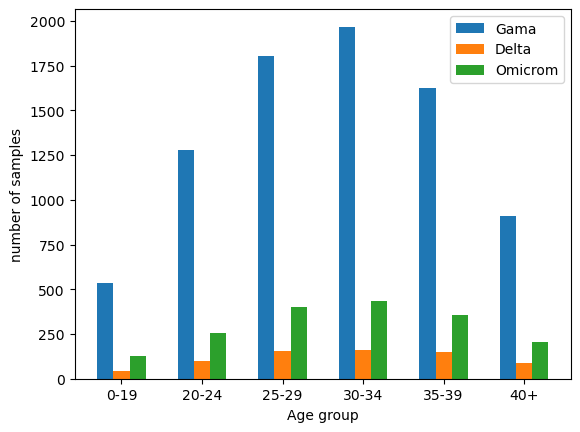


------------- Total value and percentage for the Gamma, Delta and Omicrom variants, respectively : : ----------------



,Gama N,Delta N,Omicrom N,Total
0-19,534 (6.58),45 (6.47),129 (7.22),708
20-24,1279 (15.76),98 (14.1),258 (14.45),1635
25-29,1805 (22.24),155 (22.3),399 (22.34),2359
30-34,1967 (24.23),158 (22.73),436 (24.41),2561
35-39,1625 (20.02),150 (21.58),358 (20.04),2133
40+,907 (11.17),89 (12.81),206 (11.53),1202


In [128]:
lista_idade=df['NU_IDADE_N'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_idade[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_idade[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_idade[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom
Faixa_etaria = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+']

lista_1 = []
for i in range(len(resultados)):
    if 0 <= resultados[i][0] <= 19:
        lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)):
    if 20 <= resultados[i][0] <= 24:
        lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)):
    if 25 <= resultados[i][0] <= 29:
        lista_3.append(resultados[i][1])

lista_4 = []
for i in range(len(resultados)):
    if 30 <= resultados[i][0] <= 34:
        lista_4.append(resultados[i][1])

lista_5 = []
for i in range(len(resultados)):
    if 35 <= resultados[i][0] <= 39:
        lista_5.append(resultados[i][1])

lista_6 = []
for i in range(len(resultados)):
    if resultados[i][0] >= 40:
        lista_6.append(resultados[i][1])

y1 = [lista_1.count(1), lista_2.count(1), lista_3.count(1), lista_4.count(1), lista_5.count(1), lista_6.count(1)]
y2 = [lista_1.count(2), lista_2.count(2), lista_3.count(2), lista_4.count(2), lista_5.count(2), lista_6.count(2)]
y3 = [lista_1.count(3), lista_2.count(3), lista_3.count(3), lista_4.count(3), lista_5.count(3), lista_6.count(3)]


matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa_etaria)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Graph showing the relationship between covid variant and age group : ')
print()

width = 0.2

x = np.arange(len(Faixa_etaria))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x , y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Age group")
plt.ylabel("number of samples")
plt.xticks(x, Faixa_etaria)
plt.legend()
plt.show()

print()
print('------------- Total value and percentage for the Gamma, Delta and Omicrom variants, respectively : : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]

y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa_etaria)

df_idade = df_table_int.iloc[0:6 :,0:6]
df_idade = df_idade.astype(int)
df_idade['Gama N (%)'] = df_table['Gama N (%) ']
df_idade['Delta N (%)'] = df_table['Delta N (%) ']
df_idade['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_idade = df_idade.astype(str)

df_idade['Gama N'] = df_idade.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_idade['Delta N'] = df_idade.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_idade['Omicrom N'] = df_idade.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_idade.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_idade)

Relationship between covid variant and race/color

C:\Users\User\AppData\Local\Temp\ipykernel_11456\295027128.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_11456\295027128.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_11456\295027128.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
C:\Users\User\AppData\Local\Temp\ipykernel_11456\295027128.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in range(len(df[selecao_gama])):
C:\Users\User\AppData\Local\Temp\ipykernel_11456\295027128.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in range(len(df[selecao_delta])):
C:\Users\User\AppData\Local\Temp\ipykern


------------- p value  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.6091176332432684

Failed to reject the null hypothesis.

graph showing the relationship between race and covid variant: 



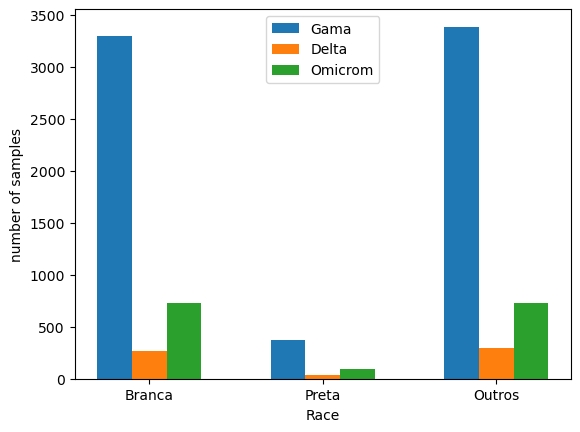


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Branca,3292 (46.71),271 (44.65),731 (47.04)
Preta,370 (5.25),38 (6.26),91 (5.86)
Outros,3386 (48.04),298 (49.09),732 (47.1)


In [129]:
lista_raça= df['CS_RACA'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_raça[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_raça[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_raça[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Raça = ['Branca','Preta', 'Outros']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_outros = [3,4,5]
lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] in lista_outros:
    lista_3.append(resultados[i][1])


y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Raça)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- p value  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('graph showing the relationship between race and covid variant: ')
print()

width = 0.2

x = np.arange(len(Raça))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x , y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Race")
plt.ylabel("number of samples")
plt.xticks(x, Raça)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Raça)

df_raca = df_table_int.iloc[0:3 :,0:3]
df_raca = df_raca.astype(int)
df_raca['Gama N (%)'] = df_table['Gama N (%) ']
df_raca['Delta N (%)'] = df_table['Delta N (%) ']
df_raca['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_raca = df_raca.astype(str)

df_raca['Gama N'] = df_raca.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_raca['Delta N'] = df_raca.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_raca['Omicrom N'] = df_raca.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_raca.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_raca)

Relationship between the covid variant and schooling


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.7452054412879108

Failed to reject the null hypothesis.

Gráfico com a relação entre a escolaridade e a variante do covid: 



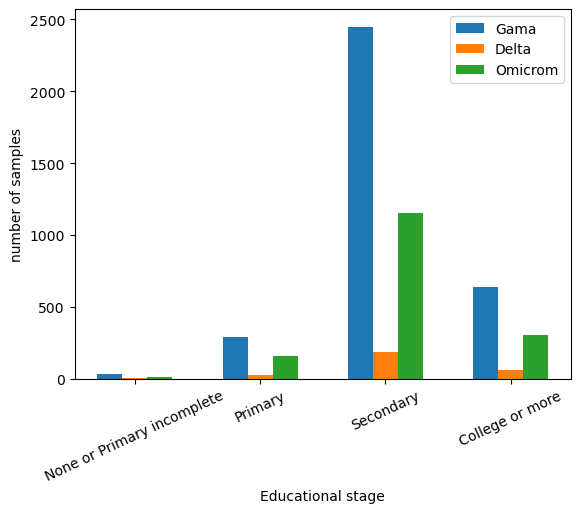


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
None or Primary incomplete,32.0 (0.94),2.0 (0.75),13.0 (0.8)
Primary,290.0 (8.5),22.0 (8.24),155.0 (9.54)
Secondary,2450.0 (71.83),186.0 (69.66),1156.0 (71.14)
College or more,639.0 (18.73),57.0 (21.35),301.0 (18.52)


In [130]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_escolaridade=df['CS_ESCOL_N'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_escolaridade[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_escolaridade[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_escolaridade[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa_escolaridade= ['None or Primary incomplete', 'Primary', 'Secondary','College or more']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 0:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_2.append(resultados[i][1])

lista_p_or_s = [2,3]
lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] in lista_p_or_s:
    lista_3.append(resultados[i][1])

lista_4 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 4:
    lista_4.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1),lista_4.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2),lista_4.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3),lista_4.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa_escolaridade)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a escolaridade e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa_escolaridade))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Educational stage")
plt.ylabel("number of samples")
plt.xticks(x, Faixa_escolaridade, rotation = 25)
plt.legend()
plt.show()

width = 0.2

x = np.arange(len(Faixa_escolaridade))

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa_escolaridade)

df_escolaridade = df_table_int.iloc[0:4 :,0:3]
df_escolaridade['Gama N (%)'] = df_table['Gama N (%) ']
df_escolaridade['Delta N (%)'] = df_table['Delta N (%) ']
df_escolaridade['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_escolaridade = df_escolaridade.astype(str)

df_escolaridade['Gama N'] = df_escolaridade.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_escolaridade['Delta N'] = df_escolaridade.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_escolaridade['Omicrom N'] = df_escolaridade.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_escolaridade.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_escolaridade)

Analysis of pregnant and postpartum women

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Gráfico com a quantidade de gestantes



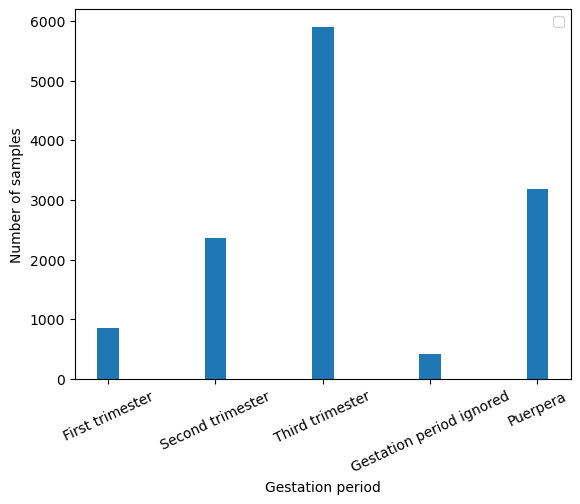


---------------- Relação entre a gravidez e a variante do covid ----------------------


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.9540626411261911

Failed to reject the null hypothesis.

Gráfico com a relação entre a gravidez e a variante do covid: 



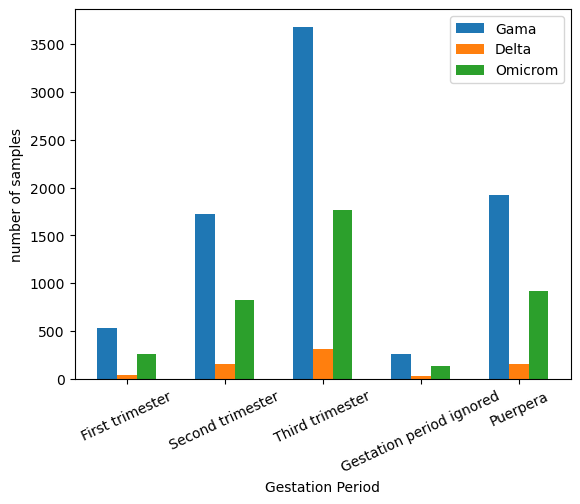


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
First trimester,530.0 (6.53),42.0 (6.04),262.0 (6.7)
Second trimester,1720.0 (21.19),152.0 (21.87),826.0 (21.13)
Third trimester,3679.0 (45.32),309.0 (44.46),1768.0 (45.23)
Gestation period ignored,265.0 (3.26),32.0 (4.6),138.0 (3.53)
Puerpera,1923.0 (23.69),160.0 (23.02),915.0 (23.41)


In [131]:
lista_gravidez=df['GRAVIDEZ'].tolist()

Faixa_gravidez = ['First trimester','Second trimester','Third trimester','Gestation period ignored', 'Puerpera']

x = np.arange(len(Faixa_gravidez))
y = [lista_gravidez.count(1),lista_gravidez.count(2), lista_gravidez.count(3),lista_gravidez.count(4),lista_gravidez.count(5)]

print()
print('Gráfico com a quantidade de gestantes')
print()

plt.bar(x, y, 0.2)

plt.xlabel("Gestation period")
plt.ylabel("Number of samples")
plt.xticks(x, Faixa_gravidez, rotation = 25)
plt.legend()
plt.show()

print()
print('---------------- Relação entre a gravidez e a variante do covid ----------------------')
print()

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gravidez=df['GRAVIDEZ'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_gravidez[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_gravidez[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_gravidez[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa_gravidez = ['First trimester','Second trimester','Third trimester','Gestation period ignored', 'Puerpera']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 3:
    lista_3.append(resultados[i][1])

lista_4 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 4:
    lista_4.append(resultados[i][1])

lista_5 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 5:
    lista_5.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1),lista_4.count(1), lista_5.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2),lista_4.count(2), lista_5.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3),lista_4.count(3), lista_5.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa_gravidez)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a gravidez e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa_gravidez))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Gestation Period")
plt.ylabel("number of samples")
plt.xticks(x, Faixa_gravidez, rotation = 25)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]

y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa_gravidez)

df_gestante = df_table_int.iloc[0:5 :,0:3]
df_gestante['Gama N (%)'] = df_table['Gama N (%) ']
df_gestante['Delta N (%)'] = df_table['Delta N (%) ']
df_gestante['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_gestante = df_gestante.astype(str)

df_gestante['Gama N'] = df_gestante.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_gestante['Delta N'] = df_gestante.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_gestante['Omicrom N'] = df_gestante.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_gestante.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_gestante)

Relationship between the covid variant and the vaccine


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.9361961932487692

Failed to reject the null hypothesis.

Gráfico com a relação entre a vacina e a variante do covid: 



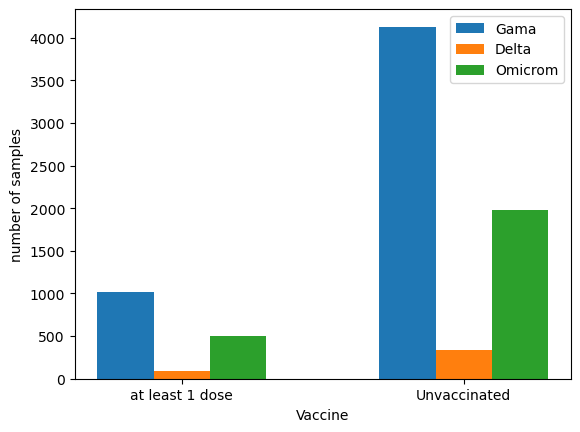


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
at least 1 dose,1019 (19.79),92 (21.5),502 (20.23)
Unvaccinated,4129 (80.21),336 (78.5),1979 (79.77)


In [138]:
df['VACINA_COV'] = df['VACINA_COV'].fillna(9)
df['VACINA_COV'] =df['VACINA_COV'].astype(int)

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_vacina = df['VACINA_COV'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_vacina[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_vacina[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_vacina[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa_vacina = ['at least 1 dose','Unvaccinated']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1)]
y2 =[lista_1.count(2),lista_2.count(2)]
y3 = [lista_1.count(3),lista_2.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa_vacina)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a vacina e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa_vacina))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Vaccine")
plt.ylabel("number of samples")
plt.xticks(x, Faixa_vacina)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa_vacina)

df_vacina = df_table_int.iloc[0:2 :,0:3]
df_vacina = df_vacina.astype(int)
df_vacina['Gama N (%)'] = df_table['Gama N (%) ']
df_vacina['Delta N (%)'] = df_table['Delta N (%) ']
df_vacina['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_vacina = df_vacina.astype(str)

df_vacina['Gama N'] = df_vacina.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_vacina['Delta N'] = df_vacina.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_vacina['Omicrom N'] = df_vacina.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_vacina.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_vacina)

relationship between region and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.7573683581027048

Failed to reject the null hypothesis.

Gráfico com a relação entre a região e a variante do covid: 



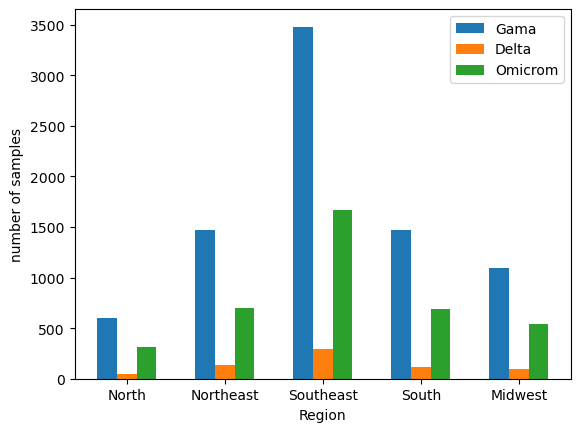


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
North,604 (7.44),49 (7.05),309 (7.9)
Northeast,1470 (18.11),135 (19.42),700 (17.91)
Southeast,3481 (42.89),292 (42.01),1668 (42.67)
South,1467 (18.07),119 (17.12),694 (17.75)
Midwest,1095 (13.49),100 (14.39),538 (13.76)


In [144]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_regiao_nome = df['Regiao_nome'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_regiao_nome[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_regiao_nome[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_regiao_nome[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa_regiao = ['North','Northeast','Southeast','South','Midwest']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 'North':
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 'Northeast':
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 'Southeast':
    lista_3.append(resultados[i][1])

lista_4 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 'South':
    lista_4.append(resultados[i][1])

lista_5 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 'Midwest':
    lista_5.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1),lista_4.count(1), lista_5.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2),lista_4.count(2), lista_5.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3),lista_4.count(3), lista_5.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa_regiao)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a região e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa_regiao))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Region")
plt.ylabel("number of samples")
plt.xticks(x, Faixa_regiao)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa_regiao)

df_regiao = df_table_int.iloc[0:5 :,0:3]
df_regiao = df_regiao.astype(int)
df_regiao['Gama N (%)'] = df_table['Gama N (%) ']
df_regiao['Delta N (%)'] = df_table['Delta N (%) ']
df_regiao['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_regiao = df_regiao.astype(str)

df_regiao['Gama N'] = df_regiao.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_regiao['Delta N'] = df_regiao.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_regiao['Omicrom N'] = df_regiao.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_regiao.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_regiao)

relationship between chronic cardiovascular disease and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.9389870557489737

Failed to reject the null hypothesis.



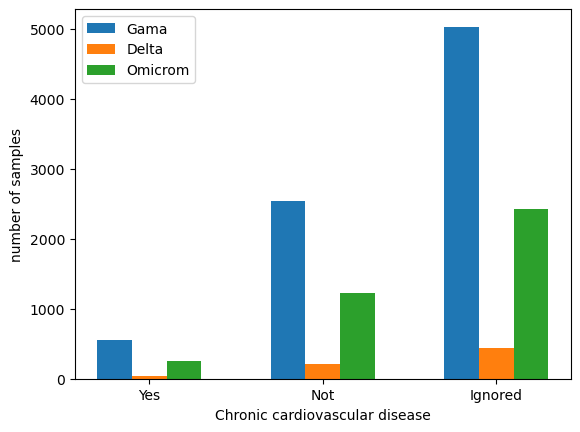


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,556 (6.85),42 (6.04),259 (6.63)
Not,2534 (31.22),217 (31.22),1223 (31.29)
Ignored,5027 (61.93),436 (62.73),2427 (62.09)


In [145]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_cardio_vascular = df['CARDIOPATI'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_cardio_vascular[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_cardio_vascular[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_cardio_vascular[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Chronic cardiovascular disease")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Cardiovascular = df_table_int.iloc[0:3 :,0:3]
df_Cardiovascular = df_Cardiovascular.astype(int)
df_Cardiovascular['Gama N (%)'] = df_table['Gama N (%) ']
df_Cardiovascular['Delta N (%)'] = df_table['Delta N (%) ']
df_Cardiovascular['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Cardiovascular = df_Cardiovascular.astype(str)

df_Cardiovascular['Gama N'] = df_Cardiovascular.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Cardiovascular['Delta N'] = df_Cardiovascular.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Cardiovascular['Omicrom N'] = df_Cardiovascular.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Cardiovascular.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Cardiovascular)

Relationship between kidney disease and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8476796876269977

Failed to reject the null hypothesis.



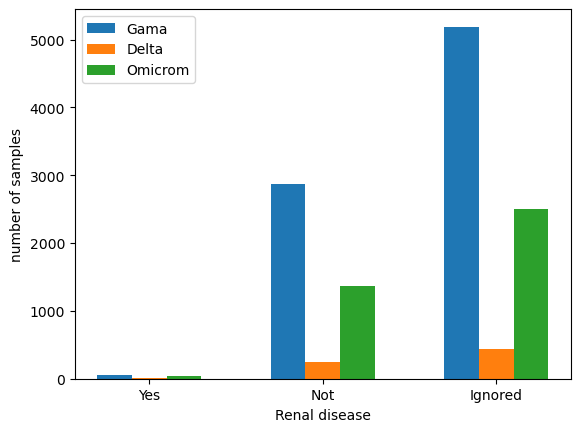


-------------  Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,57 (0.7),7 (1.01),33 (0.84)
Not,2870 (35.36),244 (35.11),1369 (35.02)
Ignored,5190 (63.94),444 (63.88),2507 (64.13)


In [146]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_renal = df['RENAL'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_renal[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_renal[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_renal[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Renal disease")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('-------------  Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Renal = df_table_int.iloc[0:3 :,0:3]
df_Renal = df_Renal.astype(int)
df_Renal['Gama N (%)'] = df_table['Gama N (%) ']
df_Renal['Delta N (%)'] = df_table['Delta N (%) ']
df_Renal['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Renal = df_Renal.astype(str)

df_Renal['Gama N'] = df_Renal.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Renal['Delta N'] = df_Renal.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Renal['Omicrom N'] = df_Renal.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Renal.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Renal)

relationship between asthma and covid variants


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8734932457705911

Failed to reject the null hypothesis.



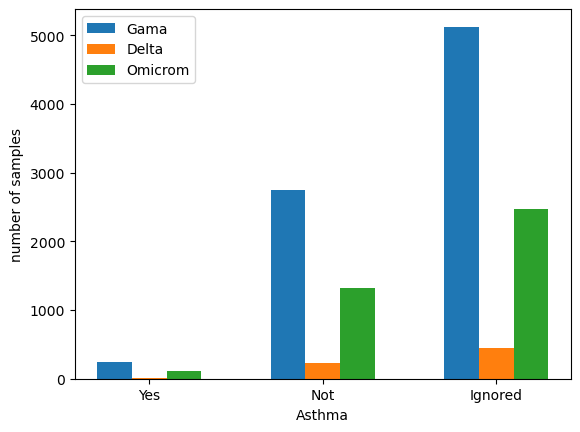


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,246 (3.03),16 (2.3),117 (2.99)
Not,2744 (33.81),235 (33.81),1315 (33.64)
Ignored,5127 (63.16),444 (63.88),2477 (63.37)


In [147]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_asma = df['ASMA'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_asma[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_asma[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_asma[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Asthma")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Asma = df_table_int.iloc[0:3 :,0:3]
df_Asma = df_Asma.astype(int)
df_Asma['Gama N (%)'] = df_table['Gama N (%) ']
df_Asma['Delta N (%)'] = df_table['Delta N (%) ']
df_Asma['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Asma = df_Asma.astype(str)

df_Asma['Gama N'] = df_Asma.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Asma['Delta N'] = df_Asma.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Asma['Omicrom N'] = df_Asma.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Asma.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Asma)

relationship between diabetes mellitus and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.40653323299817423

Failed to reject the null hypothesis.



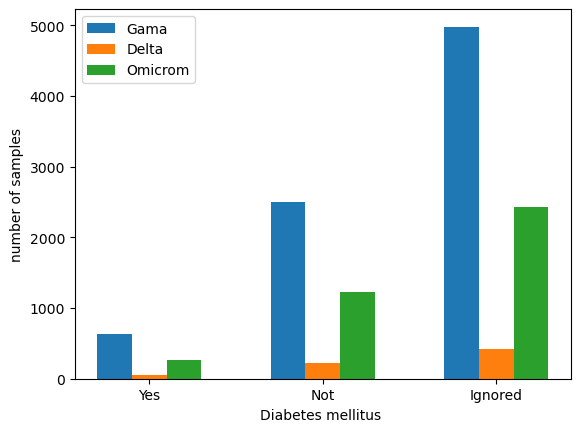


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,629 (7.75),49 (7.05),264 (6.75)
Not,2507 (30.89),219 (31.51),1221 (31.24)
Ignored,4981 (61.37),427 (61.44),2424 (62.01)


In [148]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_diabetes= df['DIABETES'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_diabetes[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_diabetes[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_diabetes[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Diabetes mellitus ")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Diabetes_mellitus = df_table_int.iloc[0:3 :,0:3]
df_Diabetes_mellitus = df_Diabetes_mellitus.astype(int)
df_Diabetes_mellitus['Gama N (%)'] = df_table['Gama N (%) ']
df_Diabetes_mellitus['Delta N (%)'] = df_table['Delta N (%) ']
df_Diabetes_mellitus['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Diabetes_mellitus = df_Diabetes_mellitus.astype(str)

df_Diabetes_mellitus['Gama N'] = df_Diabetes_mellitus.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Diabetes_mellitus['Delta N'] = df_Diabetes_mellitus.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Diabetes_mellitus['Omicrom N'] = df_Diabetes_mellitus.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Diabetes_mellitus.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Diabetes_mellitus)

relationship between other medical conditions and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.718364085129457

Failed to reject the null hypothesis.



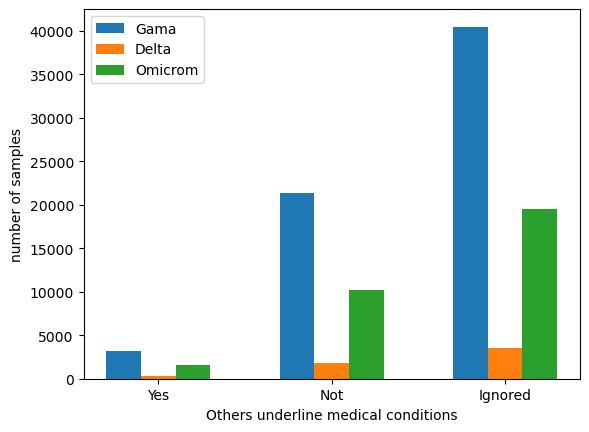


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,3142 (4.84),288 (5.18),1551 (4.96)
Not,21321 (32.83),1797 (32.32),10229 (32.71)
Ignored,40473 (62.33),3475 (62.5),19492 (62.33)


In [149]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_outros= df['OUT_MORBI'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_outros[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_outros[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_outros[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_outros = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_outros =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_outros = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_hematológica = df['HEMATOLOGI'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_hematológica[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_hematológica[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_hematológica[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_hematológica = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_hematológica =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_hematológica = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_sind_down = df['SIND_DOWN'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_sind_down[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_sind_down[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_sind_down[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_sind_down = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_sind_down =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_sind_down = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_hepatica = df['HEPATICA'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_hepatica[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_hepatica[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_hepatica[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_hepatica = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_hepatica =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_hepatica = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_neurologica = df['NEUROLOGIC'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_neurologica[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_neurologica[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_neurologica[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_neurologica = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_neurologica =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_neurologica = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_pneumopatia = df['PNEUMOPATI'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_pneumopatia[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_pneumopatia[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_pneumopatia[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_pneumopatia = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_pneumopatia =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_pneumopatia = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_imuno_depre = df['IMUNODEPRE'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_imuno_depre[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_imuno_depre[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_imuno_depre[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_imuno_depre = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_imuno_depre =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_imuno_depre = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_obesidade = df['OBESIDADE'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_obesidade[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_obesidade[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_obesidade[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_obesidade = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_obesidade =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_obesidade = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#-------------------------------------------------------------------------

y1_total_outros = [A + B + C + D + E + F + G + H for A , B , C , D , E , F , G , H in zip(y1_outros,y1_hematológica, y1_sind_down,y1_hepatica,y1_neurologica,y1_pneumopatia, y1_imuno_depre,y1_obesidade)]
y2_total_outros = [A + B + C + D + E + F + G + H for A , B , C , D , E , F , G , H in zip(y2_outros,y2_hematológica,y2_sind_down,y2_hepatica,y2_neurologica,y2_pneumopatia, y2_imuno_depre,y2_obesidade)]
y3_total_outros = [A + B + C + D + E + F + G + H for A , B , C , D , E , F , G , H in zip(y3_outros,y3_hematológica,y3_sind_down,y3_hepatica,y3_neurologica,y3_pneumopatia, y3_imuno_depre,y3_obesidade)]

matrix_table_int = np.array([y1_total_outros,y2_total_outros,y3_total_outros]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1_total_outros, width, label = 'Gama')
plt.bar(x, y2_total_outros, width, label = 'Delta')
plt.bar(x+0.2, y3_total_outros, width, label = 'Omicrom')
plt.xlabel("Others underline medical conditions")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1_total_outros[:] = [float(i) / sum(y1_total_outros) for i in y1_total_outros]
y2_total_outros[:] = [float(i) / sum(y2_total_outros) for i in y2_total_outros]
y3_total_outros[:] = [float(i) / sum(y3_total_outros) for i in y3_total_outros]

y1_total_outros = [x*100 for x in y1_total_outros]
y2_total_outros = [x*100 for x in y2_total_outros]
y3_total_outros = [x*100 for x in y3_total_outros]

y1_total_outros = [round(x,2) for x in y1_total_outros]
y2_total_outros = [round(x,2) for x in y2_total_outros]
y3_total_outros = [round(x,2) for x in y3_total_outros]

matrix_table = np.array([y1_total_outros,y2_total_outros,y3_total_outros])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_outras_condicoes_medicas = df_table_int.iloc[0:3 :,0:3]
df_outras_condicoes_medicas = df_outras_condicoes_medicas.astype(int)
df_outras_condicoes_medicas['Gama N (%)'] = df_table['Gama N (%) ']
df_outras_condicoes_medicas['Delta N (%)'] = df_table['Delta N (%) ']
df_outras_condicoes_medicas['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_outras_condicoes_medicas = df_outras_condicoes_medicas.astype(str)

df_outras_condicoes_medicas['Gama N'] = df_outras_condicoes_medicas.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_outras_condicoes_medicas['Delta N'] = df_outras_condicoes_medicas.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_outras_condicoes_medicas['Omicrom N'] = df_outras_condicoes_medicas.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_outras_condicoes_medicas.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_outras_condicoes_medicas)

Tabela 1: Características sociodemográficas e obstétricas de mulheres com infecção por SARS-CoV-2 confirmada laboratorialmente.

In [150]:
df_Asma['Classe'] = 'Asma'
df_Cardiovascular['Classe'] ='Cardiovascular'
df_Diabetes_mellitus['Classe']='Diabetes_mellitus'
df_Renal['Classe']='Renal'
df_escolaridade['Classe']='escolaridade'
df_gestante['Classe']='gestante'
df_regiao['Classe']='regiao'
df_outras_condicoes_medicas['Classe']='outras_condicoes_medicas'
df_vacina['Classe']='vacina'
df_idade['Classe'] = 'Idade'
df_raca['Classe'] = 'Raça'

df_concatenado_tabela1 = pd.concat([df_idade,df_raca,df_regiao,df_escolaridade,df_vacina,df_gestante,df_Cardiovascular,df_Renal,df_Asma,df_Diabetes_mellitus,df_outras_condicoes_medicas])
colunas_concat = df_concatenado_tabela1.columns.tolist()
colunas_concat.remove("Classe")
grupos = df_concatenado_tabela1[colunas_concat].groupby(df_concatenado_tabela1["Classe"])
for nome_grupo, grupo_df in grupos:
    print("Classe: ", nome_grupo)
    print(grupo_df)
    print("\n")

Classe:  Asma
               Gama N      Delta N     Omicrom N Total
Yes        246 (3.03)     16 (2.3)    117 (2.99)   NaN
Not      2744 (33.81)  235 (33.81)  1315 (33.64)   NaN
Ignored  5127 (63.16)  444 (63.88)  2477 (63.37)   NaN


Classe:  Cardiovascular
               Gama N      Delta N     Omicrom N Total
Yes        556 (6.85)    42 (6.04)    259 (6.63)   NaN
Not      2534 (31.22)  217 (31.22)  1223 (31.29)   NaN
Ignored  5027 (61.93)  436 (62.73)  2427 (62.09)   NaN


Classe:  Diabetes_mellitus
               Gama N      Delta N     Omicrom N Total
Yes        629 (7.75)    49 (7.05)    264 (6.75)   NaN
Not      2507 (30.89)  219 (31.51)  1221 (31.24)   NaN
Ignored  4981 (61.37)  427 (61.44)  2424 (62.01)   NaN


Classe:  Idade
             Gama N      Delta N    Omicrom N Total
0-19     534 (6.58)    45 (6.47)   129 (7.22)   708
20-24  1279 (15.76)    98 (14.1)  258 (14.45)  1635
25-29  1805 (22.24)   155 (22.3)  399 (22.34)  2359
30-34  1967 (24.23)  158 (22.73)  436 (24.41) 

**Notes


* The dataset does not contain information on parity
* The dataset does not contain information on marital status
* The df['VACINA_COV'] column does not contain the relation: complete vaccination : 1, and incomplete vaccination : 2 , but rather the relation: at least 1 dose : 1 , and no dose :2 . Thus, to determine whether the vaccination was complete (2 doses or more), we need to look at the dates of the doses, but these variables have many NaNs



**Table 2: Clinical features of SARS-CoV-2 infection among pregant and postpartum women, by SARS-COV-2 VOCs in Brazil.**

In [151]:
lista_febre = df['FEBRE'].tolist()
lista_tosse = df['TOSSE'].tolist()
lista_garganta = df['GARGANTA'].tolist()
lista_dispneia = df['DISPNEIA'].tolist()
lista_desc_resp = df['DESC_RESP'].tolist()
lista_saturacao = df['SATURACAO'].tolist()
lista_diarreia = df['DIARREIA'].tolist()
lista_vomito = df['VOMITO'].tolist()
lista_dor_abd = df['DOR_ABD'].tolist()
lista_fadiga = df['FADIGA'].tolist()
lista_perd_olft = df['PERD_OLFT'].tolist()
lista_perd_pala = df['PERD_PALA'].tolist()

relationship between fever and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.37373258234111284

Failed to reject the null hypothesis.

Gráfico com a relação entre a febre e a variante do covid: 



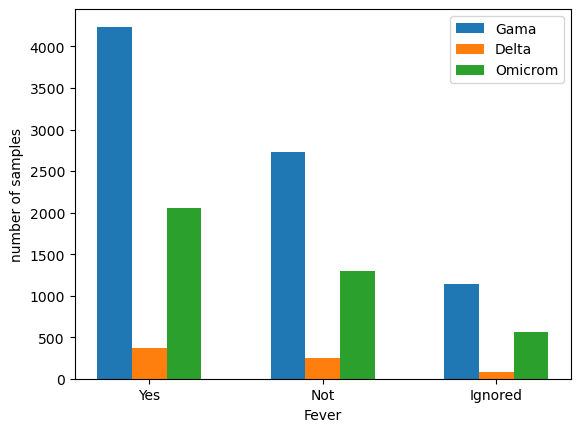


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,4238 (52.21),365 (52.52),2054 (52.55)
Not,2733 (33.67),249 (35.83),1298 (33.21)
Ignored,1146 (14.12),81 (11.65),557 (14.25)


In [152]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_febre[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_febre[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_febre[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a febre e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Fever")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_febre = df_table_int.iloc[0:3 :,0:3]
df_febre = df_febre.astype(int)
df_febre['Gama N (%)'] = df_table['Gama N (%) ']
df_febre['Delta N (%)'] = df_table['Delta N (%) ']
df_febre['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_febre = df_febre.astype(str)

df_febre['Gama N'] = df_febre.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_febre['Delta N'] = df_febre.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_febre['Omicrom N'] = df_febre.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_febre.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_febre)

relationship between cough and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.9983413504107652

Failed to reject the null hypothesis.

Gráfico com a relação entre a tosse e a variante do covid: 



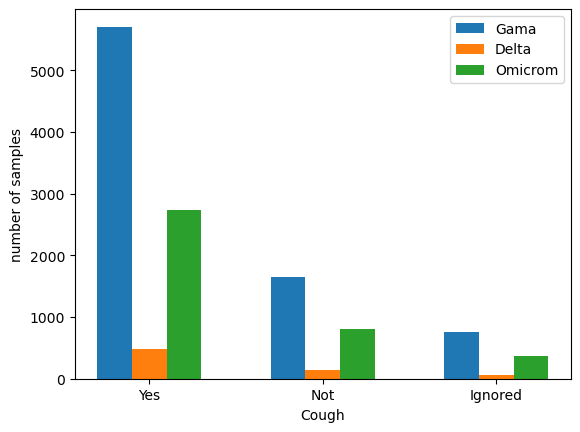


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,5705 (70.28),486 (69.93),2737 (70.02)
Not,1649 (20.32),143 (20.58),800 (20.47)
Ignored,763 (9.4),66 (9.5),372 (9.52)


In [153]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_tosse[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_tosse[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_tosse[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a tosse e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Cough")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Tosse = df_table_int.iloc[0:3 :,0:3]
df_Tosse = df_Tosse.astype(int)
df_Tosse['Gama N (%)'] = df_table['Gama N (%) ']
df_Tosse['Delta N (%)'] = df_table['Delta N (%) ']
df_Tosse['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Tosse = df_Tosse.astype(str)

df_Tosse['Gama N'] = df_Tosse.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Tosse['Delta N'] = df_Tosse.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Tosse['Omicrom N'] = df_Tosse.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Tosse.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Tosse)

relationship between Dyspnea and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.7629363680923513

Failed to reject the null hypothesis.

Gráfico com a relação entre a dispneia e a variante do covid: 



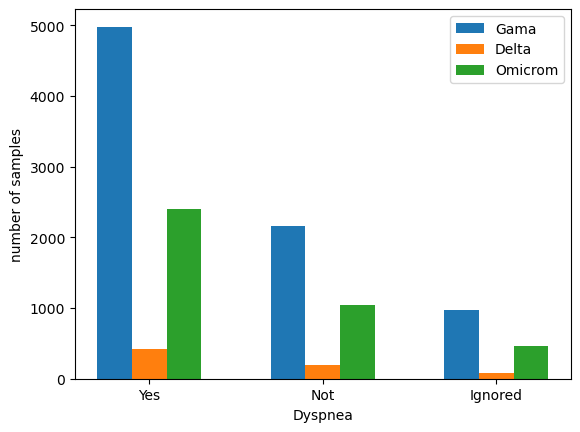


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,4979 (61.34),417 (60.0),2397 (61.32)
Not,2165 (26.67),201 (28.92),1049 (26.84)
Ignored,973 (11.99),77 (11.08),463 (11.84)


In [154]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_dispneia[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_dispneia[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_dispneia[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a dispneia e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Dyspnea")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Dispneia = df_table_int.iloc[0:3 :,0:3]
df_Dispneia = df_Dispneia.astype(int)
df_Dispneia['Gama N (%)'] = df_table['Gama N (%) ']
df_Dispneia['Delta N (%)'] = df_table['Delta N (%) ']
df_Dispneia['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Dispneia = df_Dispneia.astype(str)

df_Dispneia['Gama N'] = df_Dispneia.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Dispneia['Delta N'] = df_Dispneia.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Dispneia['Omicrom N'] = df_Dispneia.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Dispneia.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Dispneia)

relationship between diarrhea and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.49040132102720824

Failed to reject the null hypothesis.

Gráfico com a relação entre a diarreia e a variante do covid: 



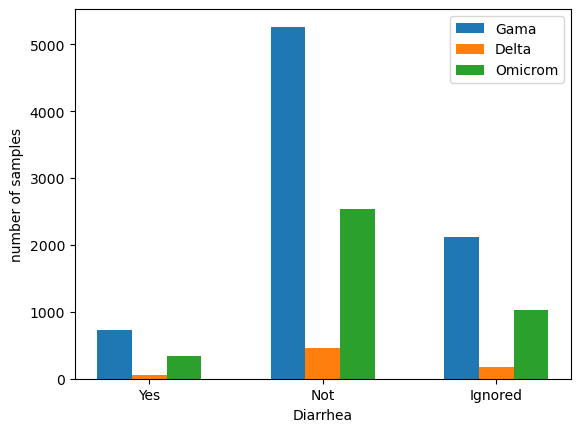


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,733 (9.03),49 (7.05),340 (8.7)
Not,5264 (64.85),465 (66.91),2539 (64.95)
Ignored,2120 (26.12),181 (26.04),1030 (26.35)


In [155]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_diarreia[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_diarreia[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_diarreia[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a diarreia e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Diarrhea")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Diarreia = df_table_int.iloc[0:3 :,0:3]
df_Diarreia = df_Diarreia.astype(int)
df_Diarreia['Gama N (%)'] = df_table['Gama N (%) ']
df_Diarreia['Delta N (%)'] = df_table['Delta N (%) ']
df_Diarreia['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Diarreia = df_Diarreia.astype(str)

df_Diarreia['Gama N'] = df_Diarreia.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Diarreia['Delta N'] = df_Diarreia.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Diarreia['Omicrom N'] = df_Diarreia.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Diarreia.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Diarreia)

Relationship between Vomito and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8866779784159556

Failed to reject the null hypothesis.

Gráfico com a relação entre o vomito e a variante do covid: 



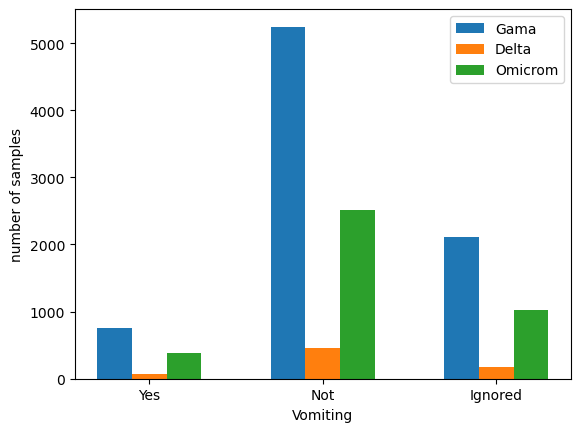


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,757 (9.33),68 (9.78),380 (9.72)
Not,5245 (64.62),455 (65.47),2508 (64.16)
Ignored,2115 (26.06),172 (24.75),1021 (26.12)


In [156]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_vomito[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_vomito[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_vomito[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre o vomito e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Vomiting")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Vomito = df_table_int.iloc[0:3 :,0:3]
df_Vomito = df_Vomito.astype(int)
df_Vomito['Gama N (%)'] = df_table['Gama N (%) ']
df_Vomito['Delta N (%)'] = df_table['Delta N (%) ']
df_Vomito['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Vomito = df_Vomito.astype(str)

df_Vomito['Gama N'] = df_Vomito.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Vomito['Delta N'] = df_Vomito.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Vomito['Omicrom N'] = df_Vomito.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Vomito.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Vomito)

relationship between fatigue and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8726120276477883

Failed to reject the null hypothesis.

Gráfico com a relação entre a fadiga e a variante do covid: 



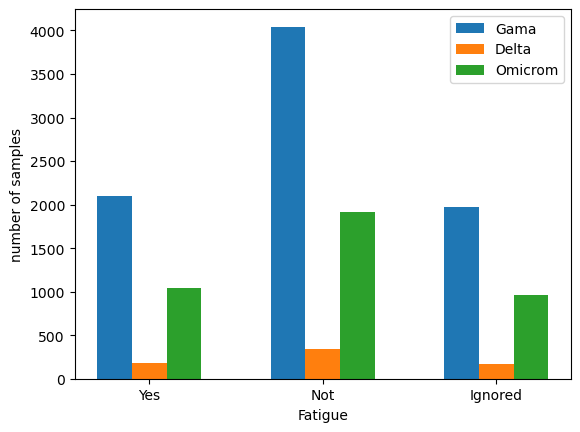


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,2098 (25.85),184 (26.47),1037 (26.53)
Not,4043 (49.81),347 (49.93),1911 (48.89)
Ignored,1976 (24.34),164 (23.6),961 (24.58)


In [157]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_fadiga[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_fadiga[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_fadiga[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a fadiga e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Fatigue")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Fadiga = df_table_int.iloc[0:3 :,0:3]
df_Fadiga = df_Fadiga.astype(int)
df_Fadiga['Gama N (%)'] = df_table['Gama N (%) ']
df_Fadiga['Delta N (%)'] = df_table['Delta N (%) ']
df_Fadiga['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Fadiga = df_Fadiga.astype(str)

df_Fadiga['Gama N'] = df_Fadiga.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Fadiga['Delta N'] = df_Fadiga.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Fadiga['Omicrom N'] = df_Fadiga.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Fadiga.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Fadiga)

relationship between sore throat and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.7865636369510413

Failed to reject the null hypothesis.

Gráfico com a relação entre a dor de garganta e a variante do covid: 



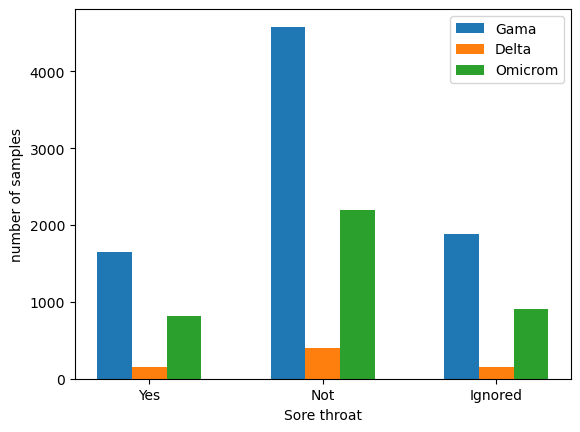


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,1649 (20.32),148 (21.29),810 (20.72)
Not,4582 (56.45),399 (57.41),2191 (56.05)
Ignored,1886 (23.24),148 (21.29),908 (23.23)


In [158]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_garganta[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_garganta[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_garganta[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a dor de garganta e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Sore throat")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]

y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Garganta = df_table_int.iloc[0:3 :,0:3]
df_Garganta = df_Garganta.astype(int)
df_Garganta['Gama N (%)'] = df_table['Gama N (%) ']
df_Garganta['Delta N (%)'] = df_table['Delta N (%) ']
df_Garganta['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Garganta = df_Garganta.astype(str)

df_Garganta['Gama N'] = df_Garganta.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Garganta['Delta N'] = df_Garganta.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Garganta['Omicrom N'] = df_Garganta.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Garganta.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Garganta)

relationship between loss of smell and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.9769376210846665

Failed to reject the null hypothesis.

Gráfico com a relação entre a perda de olfato e a variante do covid: 



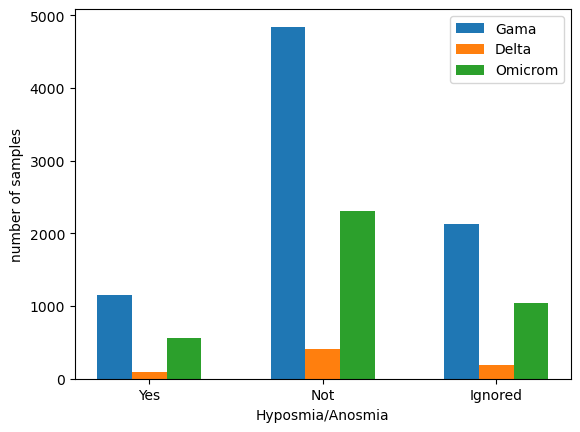


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,1149 (14.16),98 (14.1),559 (14.3)
Not,4841 (59.64),412 (59.28),2307 (59.02)
Ignored,2127 (26.2),185 (26.62),1043 (26.68)


In [159]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_perd_olft[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_perd_olft[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_perd_olft[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a perda de olfato e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Hyposmia/Anosmia")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Perda_Olfato = df_table_int.iloc[0:3 :,0:3]
df_Perda_Olfato = df_Perda_Olfato.astype(int)
df_Perda_Olfato['Gama N (%)'] = df_table['Gama N (%) ']
df_Perda_Olfato['Delta N (%)'] = df_table['Delta N (%) ']
df_Perda_Olfato['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Perda_Olfato = df_Perda_Olfato.astype(str)

df_Perda_Olfato['Gama N'] = df_Perda_Olfato.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Perda_Olfato['Delta N'] = df_Perda_Olfato.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Perda_Olfato['Omicrom N'] = df_Perda_Olfato.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Perda_Olfato.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Perda_Olfato)

relationship between loss of taste and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8445390443248323

Failed to reject the null hypothesis.

Gráfico com a relação entre a perda de paladar e a variante do covid: 



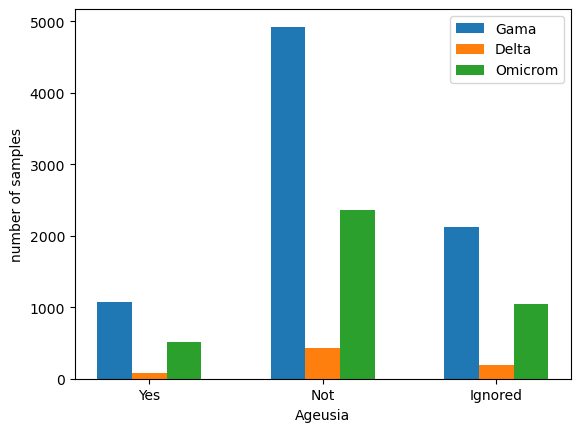


------------- Valor Total e porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,1072 (13.21),82 (11.8),512 (13.1)
Not,4922 (60.64),427 (61.44),2356 (60.27)
Ignored,2123 (26.15),186 (26.76),1041 (26.63)


In [160]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_perd_pala[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_perd_pala[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_perd_pala[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a perda de paladar e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Ageusia")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Perda_Paladar = df_table_int.iloc[0:3 :,0:3]
df_Perda_Paladar = df_Perda_Paladar.astype(int)
df_Perda_Paladar['Gama N (%)'] = df_table['Gama N (%) ']
df_Perda_Paladar['Delta N (%)'] = df_table['Delta N (%) ']
df_Perda_Paladar['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Perda_Paladar = df_Perda_Paladar.astype(str)

df_Perda_Paladar['Gama N'] = df_Perda_Paladar.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Perda_Paladar['Delta N'] = df_Perda_Paladar.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Perda_Paladar['Omicrom N'] = df_Perda_Paladar.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Perda_Paladar.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Perda_Paladar)

relationship between saturation and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8900024151857227

Failed to reject the null hypothesis.

Gráfico com a relação entre a saturação e a variante do covid: 



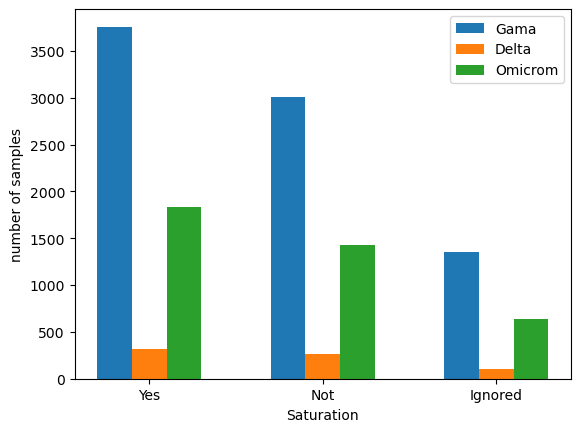


------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,3758 (46.3),321 (46.19),1837 (46.99)
Not,3006 (37.03),265 (38.13),1432 (36.63)
Ignored,1353 (16.67),109 (15.68),640 (16.37)


In [161]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_saturacao[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_saturacao[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_saturacao[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a saturação e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Saturation")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Valor Total e Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]

y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Saturacao = df_table_int.iloc[0:3 :,0:3]
df_Saturacao = df_Saturacao.astype(int)
df_Saturacao['Gama N (%)'] = df_table['Gama N (%) ']
df_Saturacao['Delta N (%)'] = df_table['Delta N (%) ']
df_Saturacao['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Saturacao = df_Saturacao.astype(str)

df_Saturacao['Gama N'] = df_Saturacao.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Saturacao['Delta N'] = df_Saturacao.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Saturacao['Omicrom N'] = df_Saturacao.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Saturacao.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Saturacao)

relationship between abdominal pain and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.3784756054550964

Failed to reject the null hypothesis.

Gráfico com a relação entre a dor abdominal e a variante do covid: 



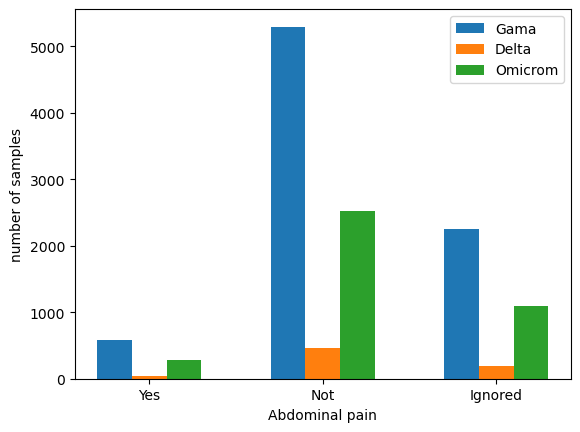


------------- Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------



,Gama N,Delta N,Omicrom N
Yes,578 (7.12),37 (5.32),286 (7.32)
Not,5294 (65.22),469 (67.48),2530 (64.72)
Ignored,2245 (27.66),189 (27.19),1093 (27.96)


In [162]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_dor_abd[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_dor_abd[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_dor_abd[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()
print('Gráfico com a relação entre a dor abdominal e a variante do covid: ')
print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Abdominal pain")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Porcentagem para as variantes Gama, Delta e Omicrom, respectivamente : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Dor_Abdominal = df_table_int.iloc[0:3 :,0:3]
df_Dor_Abdominal = df_Dor_Abdominal.astype(int)
df_Dor_Abdominal['Gama N (%)'] = df_table['Gama N (%) ']
df_Dor_Abdominal['Delta N (%)'] = df_table['Delta N (%) ']
df_Dor_Abdominal['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Dor_Abdominal = df_Dor_Abdominal.astype(str)

df_Dor_Abdominal['Gama N'] = df_Dor_Abdominal.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Dor_Abdominal['Delta N'] = df_Dor_Abdominal.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Dor_Abdominal['Omicrom N'] = df_Dor_Abdominal.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Dor_Abdominal.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Dor_Abdominal)

Table 2: Clinical features of SARS-CoV-2 infection among pregant and postpartum women, by SARS-COV-2 VOCs in Brazil.

In [163]:
df_Diarreia['Classe'] = 'Diarreia'
df_Garganta['Classe'] = 'Garganta'
df_Perda_Olfato['Classe'] = 'Perda_Olfato'
df_Perda_Paladar['Classe'] = 'Perda_Paladar'
df_Saturacao['Classe'] = 'df_Saturacao'
df_Vomito['Classe'] = 'Vomito'
df_Dor_Abdominal['Classe'] = 'Dor_Abdominal'
df_Fadiga['Classe'] = 'Fadiga'
df_Dispneia['Classe'] = 'Dispneia'
df_Tosse['Classe'] = 'Tosse'
df_febre['Classe'] = 'febre'

df_concatenado_tabela2 = pd.concat([df_Diarreia,df_Garganta,df_Perda_Olfato,df_Perda_Paladar,df_Saturacao,df_Vomito,df_Dor_Abdominal,df_Fadiga,df_Dispneia,df_Tosse,df_febre])
colunas_concat2 = df_concatenado_tabela2.columns.tolist()
colunas_concat2.remove("Classe")
grupos2 = df_concatenado_tabela2[colunas_concat2].groupby(df_concatenado_tabela2["Classe"])
for nome_grupo, grupo_df in grupos2:
    print("Classe: ", nome_grupo)
    print(grupo_df)
    print("\n")

Classe:  Diarreia
               Gama N      Delta N     Omicrom N
Yes        733 (9.03)    49 (7.05)     340 (8.7)
Not      5264 (64.85)  465 (66.91)  2539 (64.95)
Ignored  2120 (26.12)  181 (26.04)  1030 (26.35)


Classe:  Dispneia
               Gama N      Delta N     Omicrom N
Yes      4979 (61.34)   417 (60.0)  2397 (61.32)
Not      2165 (26.67)  201 (28.92)  1049 (26.84)
Ignored   973 (11.99)   77 (11.08)   463 (11.84)


Classe:  Dor_Abdominal
               Gama N      Delta N     Omicrom N
Yes        578 (7.12)    37 (5.32)    286 (7.32)
Not      5294 (65.22)  469 (67.48)  2530 (64.72)
Ignored  2245 (27.66)  189 (27.19)  1093 (27.96)


Classe:  Fadiga
               Gama N      Delta N     Omicrom N
Yes      2098 (25.85)  184 (26.47)  1037 (26.53)
Not      4043 (49.81)  347 (49.93)  1911 (48.89)
Ignored  1976 (24.34)   164 (23.6)   961 (24.58)


Classe:  Garganta
               Gama N      Delta N     Omicrom N
Yes      1649 (20.32)  148 (21.29)   810 (20.72)
Not      4582 (56

**Table 3: Risk estimates for adverse maternal and perinatal outcomes among COVID-19 infection labratory confirmed cases, by the SARS-COV-2 VOCs, adjusted for maternal demographic & obstetric characteristic and comorbidity in Brazil and region. (Logistic regression model).**

•	Logistic regression model to estimate the adjusted OR and unadjusted OR for severe maternal and perinatal outcomes, by SARS- COV-2 VOCs, in brazil and regions.

1. Table 3: Risk estimates for adverse maternal and perinatal outcomes among COVID-19 infection laboratory-confirmed case:


nesta tabela me parece que os valores de OR ajustado e não ajustado para o desfecho internação na UTI estão alterados (pelo valor obtido para que a variante Omicron foi considerada como controle) - redução de risco. E para calculo do risco de óbito foi considerada como exposição.  Considerando como exposição o risco de internação na UTI (calculo rápido usando os valores absolutos) ficaria:


Gama vs Omicron - OR: 4.39, 95 % CI: 3.87 to 4.98, p < 0.0001 e Delta vs omicron – OR: 4.44,  95% CI: 3.77 to 5.22, p < 0.0001
tem como checar esse calculo?


 Para mesma tabela ficou faltando o OR ajustado e não ajustado pra a comparação entre Gama Vs Delta

Logistic Regression for Covid Variant (GAMA VS OMICROM)

In [168]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy() #gama versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] < 4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace = True, drop = True)

# transformar 3 em 0

dic_covid = {1:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # exposed group : omicrom, non-exposed : gama

model_UTI = smf.logit("VARIANTE_COVID ~ UTI",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "OR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[1:3]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "OR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:3]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print()
print("Odds ratios :")
print(odds_ratios)
print()

crosstab_gama_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_omicrom_UTI)
print()

crosstab_gama_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_omicrom_EVOLUCAO.rename(columns = {2:"CURA", 1: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_omicrom_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.585944
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                10333
Model:                          Logit   Df Residuals:                    10331
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:                 0.06001
Time:                        02:32:50   Log-Likelihood:                -6054.6
converged:                       True   LL-Null:                       -6441.1
Covariance Type:            nonrobust   LLR p-value:                3.893e-170
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4192      0.112     30.427      0.000       3.199       3.639
UTI           -1.4908      0.

Logistic Regression for Covid Variant (GAMA VS OMICROM) -Adjusted for age, gestational period, region, skin color, vaccination status

In [169]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy()#gama versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp = df_temp.loc[df['CS_RACA'] != 9]
df_temp = df_temp.loc[df['VACINA_COV'] <3]
df_temp = df_temp.loc[df['CS_ESCOL_N'] != 5]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp = df_temp.loc[df['CARDIOPATI'] != 9]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 2 em 0
dic = {1:1, 2:0}
dic_covid = {1:1,3:0}
dic_raca = {1:'Branca', 2:'Preta',3:'Amarela',4:'Parda',5:'Indigena'}
dic_obesi = {1:'Sim', 2:'Não'}
dic_cardio = {1:'Sim', 2:'Não'}
dic_diabe = {1:'Sim', 2:'Não'}
dic_escol = {0:'Sem escolaridade', 1:'Fundamental 1',2:'Fundamental 2',3:'Médio',4:'Superior'}
dic_gravidez = {1:'Trimestre 1', 2:'Trimestre 2',3:'Trimestre 3',4:'Idade Gestacional Ignorada',5:'Puerperas'}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : gama, false : omicrom
df_temp['CS_RACA']=df_temp['CS_RACA'].map(dic_raca)
df_temp['GRAVIDEZ'] = df_temp['GRAVIDEZ'].map(dic_gravidez)
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].map(dic)
#df_temp['NU_IDADE_N'] = (df_temp['NU_IDADE_N'] - df_temp['NU_IDADE_N'].min()) / (df_temp['NU_IDADE_N'].max() - df_temp['NU_IDADE_N'].min()) #normalização da variável idade
df_temp['Age_group'] = pd.cut(df_temp['NU_IDADE_N'], bins = [0, 20, 25, 30, 35, 40, 99], include_lowest = True, labels = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+'])
df_temp['CARDIOPATI'] = df_temp['CARDIOPATI'].map(dic_cardio)
df_temp['DIABETES'] = df_temp['DIABETES'].map(dic_diabe)
df_temp['OBESIDADE'] = df_temp['OBESIDADE'].map(dic_obesi)
df_temp['CS_ESCOL_N'] = df_temp['CS_ESCOL_N'].map(dic_escol)


model_UTI = smf.logit("VARIANTE_COVID ~ UTI + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE ",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "aOR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[13:14]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "aOR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:26]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_gama_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_omicrom_UTI)
print()

crosstab_gama_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_omicrom_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_omicrom_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.394827
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                 1620
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                           25
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:                  0.4058
Time:                        02:33:13   Log-Likelihood:                -639.62
converged:                       True   LL-Null:                       -1076.5
Covariance Type:            nonrobust   LLR p-value:                3.305e-168
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.4564      1.490      2.991     

Logistic regression for Covid Variant (DELTA VS OMICROM)

In [170]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] > 1].copy()#delta versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 3 em 0
dic_covid = {2:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom

model_UTI = smf.logit("VARIANTE_COVID ~ UTI",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "OR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[1:3]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "OR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:3]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_delta_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_delta_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_delta_omicrom_UTI)
print()

crosstab_delta_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_delta_omicrom_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_delta_omicrom_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.403001
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                 3844
Model:                          Logit   Df Residuals:                     3842
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:                 0.05505
Time:                        02:33:30   Log-Likelihood:                -1549.1
converged:                       True   LL-Null:                       -1639.4
Covariance Type:            nonrobust   LLR p-value:                 3.750e-41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8277      0.181      4.573      0.000       0.473       1.182
UTI           -1.4303      0.

Logistic Regression for Covid Variant (DELTA VS OMICROM) -Adjusted for age, gestational period, region, skin color, vaccination status

In [171]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] > 1].copy()#delta versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp = df_temp.loc[df['CS_RACA'] != 9]
df_temp = df_temp.loc[df['VACINA_COV'] <3]
df_temp = df_temp.loc[df['CS_ESCOL_N'] != 5]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp = df_temp.loc[df['CARDIOPATI'] != 9]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 3 em 0
dic = {2:1, 3:0}
dic_covid = {2:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom
dic_raca = {1:'Branca', 2:'Preta',3:'Amarela',4:'Parda',5:'Indigena'}
dic_gravidez = {1:'Trimestre 1', 2:'Trimestre 2',3:'Trimestre 3',4:'Idade Gestacional Ignorada',5:'Puerperas'}
df_temp['CS_RACA']=df_temp['CS_RACA'].map(dic_raca)
df_temp['GRAVIDEZ'] = df_temp['GRAVIDEZ'].map(dic_gravidez)
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].map(dic)
#df_temp['NU_IDADE_N'] = (df_temp['NU_IDADE_N'] - df_temp['NU_IDADE_N'].min()) / (df_temp['NU_IDADE_N'].max() - df_temp['NU_IDADE_N'].min()) #normalização da variável idade
df_temp['Age_group'] = pd.cut(df_temp['NU_IDADE_N'], bins = [0, 20, 25, 30, 35, 40, 99], include_lowest = True, labels = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+'])
df_temp['CARDIOPATI'] = df_temp['CARDIOPATI'].map(dic_cardio)
df_temp['DIABETES'] = df_temp['DIABETES'].map(dic_diabe)
df_temp['OBESIDADE'] = df_temp['OBESIDADE'].map(dic_obesi)
df_temp['CS_ESCOL_N'] = df_temp['CS_ESCOL_N'].map(dic_escol)

model_UTI = smf.logit("VARIANTE_COVID ~ UTI + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "aOR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[13:14]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "aOR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:26]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_delta_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_delta_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_delta_omicrom_UTI)
print()

crosstab_delta_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_delta_omicrom_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_delta_omicrom_EVOLUCAO)

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

Logistic Regression for Covid Variant (GAMA VS DELTA)

In [172]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 2 em 0
dic_covid = {1:1,2:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : Gama, false : Delta

model_UTI = smf.logit("VARIANTE_COVID ~ UTI",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "OR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[1:3]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "OR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:3]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_gama_delta_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_delta_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_delta_UTI)
print()

crosstab_gama_delta_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_delta_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_delta_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.269810
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                 7659
Model:                          Logit   Df Residuals:                     7657
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:               0.0001101
Time:                        02:34:27   Log-Likelihood:                -2066.5
converged:                       True   LL-Null:                       -2066.7
Covariance Type:            nonrobust   LLR p-value:                    0.5000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5915      0.154     16.856      0.000       2.290       2.893
UTI           -0.0604      0.

Logistic Regression for Covid Variant (GAMA VS DELTA)-Adjusted for age, gestational period, region, skin color, vaccination status

In [173]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp = df_temp.loc[df['CS_RACA'] != 9]
df_temp = df_temp.loc[df['VACINA_COV'] <3]
df_temp = df_temp.loc[df['CS_ESCOL_N'] != 5]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp = df_temp.loc[df['CARDIOPATI'] != 9]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 2 em 0
dic = {1:1, 2:0}
dic_covid = {1:1,2:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom
dic_raca = {1:'Branca', 2:'Preta',3:'Amarela',4:'Parda',5:'Indigena'}
dic_gravidez = {1:'Trimestre 1', 2:'Trimestre 2',3:'Trimestre 3',4:'Idade Gestacional Ignorada',5:'Puerperas'}
df_temp['CS_RACA']=df_temp['CS_RACA'].map(dic_raca)
df_temp['GRAVIDEZ'] = df_temp['GRAVIDEZ'].map(dic_gravidez)
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].map(dic)
#df_temp['NU_IDADE_N'] = (df_temp['NU_IDADE_N'] - df_temp['NU_IDADE_N'].min()) / (df_temp['NU_IDADE_N'].max() - df_temp['NU_IDADE_N'].min()) #normalização da variável idade
df_temp['Age_group'] = pd.cut(df_temp['NU_IDADE_N'], bins = [0, 20, 25, 30, 35, 40, 99], include_lowest = True, labels = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+'])
df_temp['CARDIOPATI'] = df_temp['CARDIOPATI'].map(dic_cardio)
df_temp['DIABETES'] = df_temp['DIABETES'].map(dic_diabe)
df_temp['OBESIDADE'] = df_temp['OBESIDADE'].map(dic_obesi)
df_temp['CS_ESCOL_N'] = df_temp['CS_ESCOL_N'].map(dic_escol)

model_UTI = smf.logit("VARIANTE_COVID ~ UTI + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "aOR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[13:14]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "aOR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:26]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_gama_delta_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_delta_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_delta_UTI)
print()

crosstab_gama_delta_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_delta_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_delta_EVOLUCAO)

         Current function value: 0.231879
         Iterations: 35


LinAlgError: Singular matrix

Check for Multicollinearity:

Examine the correlation matrix or variance inflation factor (VIF) for your independent variables to identify highly correlated predictors.
Remove or combine variables that are too highly correlated.
Reduce the Number of Predictors:

If you have a large number of predictors compared to the number of observations, consider reducing the number of predictors or increasing the sample size.
Regularization Techniques:

Consider using regularization techniques like L1 (Lasso) or L2 (Ridge) regularization to penalize certain coefficients and prevent overfitting.
Feature Engineering:

Create new features or combinations of existing features that may help address multicollinearity.

In [174]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop the dependent variable and any categorical variables without numerical representation
X = df_temp[['UTI', 'Age_group', 'VACINA_COV', 'CS_ESCOL_N', 'CARDIOPATI', 'OBESIDADE']]

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF data
print(vif_data)

TypeError: '>=' not supported between instances of 'str' and 'float'

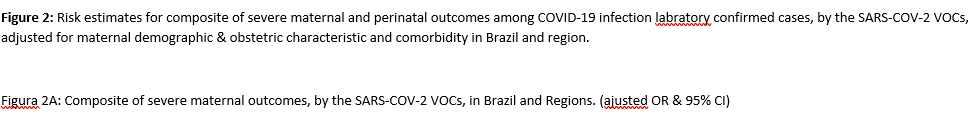

Logistic regression for Covid Variant (DELTA VS OMICROM) for each region

In [175]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] > 1].copy()  # Fazer uma cópia do subconjunto de dados
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace=True, drop=True)
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * 0

lista_obito = [2, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0

# transformar 2 em 0

dic_covid = {2:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom

#delimitar o dataset para cada região

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Sudeste']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'Sul']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Nordeste']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Centro-oeste']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'Norte']

region_list = ['Sudeste', 'Sul', 'Nordeste', 'Centro_oeste', 'Norte', 'Brasil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI= []
upperCI = []

for region, data_ in zip(region_list, data_list):
   with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit()
      #print()
      #print(f"Modelo para a região {region}:")
      #print()
      #print(model.summary())
      odds_ratios.append(np.exp(model.params[1]))
      lowerCI.append(np.exp(model.conf_int()[0][1]))
      upperCI.append(np.exp(model.conf_int()[1][1]))

or_ = pd.DataFrame({"OR": odds_ratios,"Lower CI": lowerCI,"Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_,2)
print()
display(or_)
print()
y = list(or_.index)
x = list(or_['OR'])

x_errormin = list(or_['Lower CI'])
x_errormax = list(or_['Upper CI'])

x_errormin = list(map(lambda x, y: x - y, x, x_errormin))
x_errormax = list(map(lambda x, y: x - y, x_errormax, x))

x_error = [x_errormin, x_errormax]

width = 0.2

plt.errorbar(x, y, xerr=x_error, fmt="ko")
plt.xlabel("Odds ratio")
plt.title('Associação entre Região e a infecção do SARS-CoV-2 (Delta VS Omicrom)')
plt.xlim(0,5)
plt.legend()
plt.show()

crosstab_delta_omicrom_REGIAO = pd.crosstab(df_temp['Regiao_nome'],df_temp['VARIANTE_COVID'])
crosstab_delta_omicrom_REGIAO.rename(columns = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de casos das variantes para cada região:")
print(crosstab_delta_omicrom_REGIAO)

ValueError: zero-size array to reduction operation maximum which has no identity

Logistic regression for Covid Variant (GAMA VS OMICROM) for each region

In [176]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy()  # Fazer uma cópia do subconjunto de dados
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace=True, drop=True)
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * 0

lista_obito = [2, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0

# transformar 3 em 0

dic_covid = {1:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : gama, false : omicrom

#delimitar o dataset para cada região

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Sudeste']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'Sul']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Nordeste']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Centro-oeste']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'Norte']

region_list = ['Sudeste', 'Sul', 'Nordeste', 'Centro_oeste', 'Norte', 'Brasil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI= []
upperCI = []

for region, data_ in zip(region_list, data_list):
   with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit()
      #print()
      #print(f"Modelo para a região {region}:")
      #print()
      #print(model.summary())
      odds_ratios.append(np.exp(model.params[1]))
      lowerCI.append(np.exp(model.conf_int()[0][1]))
      upperCI.append(np.exp(model.conf_int()[1][1]))

or_ = pd.DataFrame({"OR": odds_ratios,"Lower CI": lowerCI,"Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_,2)
print()
display(or_)
print()
y = list(or_.index)
x = list(or_['OR'])

x_errormin = list(or_['Lower CI'])
x_errormax = list(or_['Upper CI'])

x_errormin = list(map(lambda x, y: x - y, x, x_errormin))
x_errormax = list(map(lambda x, y: x - y, x_errormax, x))

x_error = [x_errormin, x_errormax]

width = 0.2

plt.errorbar(x, y, xerr=x_error, fmt="ko")
plt.xlabel("Odds ratio")
#plt.title('Associação entre Região e a infecção do SARS-CoV-2 (Delta VS Omicrom)')
plt.xlim(0,2.5)
plt.legend()
plt.show()

crosstab_gama_omicrom_REGIAO = pd.crosstab(df_temp['Regiao_nome'],df_temp['VARIANTE_COVID'])
crosstab_gama_omicrom_REGIAO.rename(columns = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de casos das variantes para cada região:")
print(crosstab_gama_omicrom_REGIAO)

ValueError: zero-size array to reduction operation maximum which has no identity

Optimization terminated successfully.
         Current function value: 0.450310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473311
         Iterations 5



,OR,Lower CI,Upper CI
Sudeste,0.87,0.68,1.12
Sul,1.17,0.82,1.67
Nordeste,1.49,1.07,2.06
Centro_oeste,0.51,0.27,0.97
Norte,1.03,0.65,1.62
Brasil,0.99,0.85,1.16


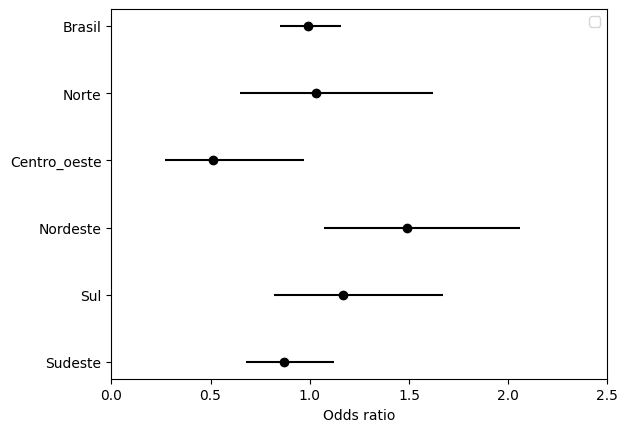


Número de casos das variantes para cada região:
VARIANTE_COVID  DELTA  GAMA
Regiao_nome                
Centro-oeste      202   876
Nordeste          235  1206
Norte             125   494
Sudeste           583  2916
Sul               324  1143


In [ ]:
#@title Regressão logística para Variante Covid (GAMA VS DELTA) para cada região
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()  # Fazer uma cópia do subconjunto de dados
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace=True, drop=True)
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * 0

lista_obito = [2, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0

# transformar 2 em 0

dic_covid = {1:1,2:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : gama, false : delta

#delimitar o dataset para cada região

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Sudeste']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'Sul']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Nordeste']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Centro-oeste']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'Norte']

region_list = ['Sudeste', 'Sul', 'Nordeste', 'Centro_oeste', 'Norte', 'Brasil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI= []
upperCI = []

for region, data_ in zip(region_list, data_list):
   with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit()
      #print()
      #print(f"Modelo para a região {region}:")
      #print()
      #print(model.summary())
      odds_ratios.append(np.exp(model.params[1]))
      lowerCI.append(np.exp(model.conf_int()[0][1]))
      upperCI.append(np.exp(model.conf_int()[1][1]))

or_ = pd.DataFrame({"OR": odds_ratios,"Lower CI": lowerCI,"Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_,2)
print()
display(or_)
print()
y = list(or_.index)
x = list(or_['OR'])

x_errormin = list(or_['Lower CI'])
x_errormax = list(or_['Upper CI'])

x_errormin = list(map(lambda x, y: x - y, x, x_errormin))
x_errormax = list(map(lambda x, y: x - y, x_errormax, x))

x_error = [x_errormin, x_errormax]

width = 0.2

plt.errorbar(x, y, xerr=x_error, fmt="ko")
plt.xlabel("Odds ratio")
#plt.title('Associação entre Região e a infecção do SARS-CoV-2 (Delta VS Omicrom)')
plt.xlim(0,2.5)
plt.legend()
plt.show()

crosstab_gama_delta_REGIAO = pd.crosstab(df_temp['Regiao_nome'],df_temp['VARIANTE_COVID'])
crosstab_gama_delta_REGIAO.rename(columns = {0:"DELTA", 1:"GAMA"} ,inplace = True)
print()
print("Número de casos das variantes para cada região:")
print(crosstab_gama_delta_REGIAO)

**Table 3: Association of Clinical features of SARS-CoV-2 infection at admission and adverse maternal outcomes, by SARS-COV-2 VOCs,  in Brazil and regions.  (one table fo each outcome ICU admission, Intubation, maternal death).**

In [ ]:
#@title Regressão logística para UTI (ICU admission)
vars = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO','DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']
colunas = ['UTI', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']

df_temp = df.copy()
for coluna in colunas:
    df_temp = df_temp.loc[df_temp[coluna] < 3]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
dic = {1:1, 2:0}
df_temp = df_temp.applymap(lambda x: dic.get(x, x))

selecao_gama = (df_temp['DT_COLETA'] >= '2021-03-01') & (df_temp['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df_temp['DT_COLETA'] >= '2021-09-01') & (df_temp['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df_temp['DT_COLETA'] >= '2022-01-01') & (df_temp['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df_temp[selecao_gama]
df_selecao_delta = df_temp[selecao_delta]
df_selecao_omicrom = df_temp[selecao_omicrom]

#criando modelo de Regressão Logística apenas para os p-values
models = {}
p_values = {}
for i, feature in enumerate(vars):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        models[f"model_{i}"] = smf.logit(f"UTI ~ {feature}", data=df_temp).fit(disp=0)
        p_values[f"p_value_{i}"] = models[f"model_{i}"].pvalues[1]

lista_p_values = list(p_values.values())
lista_p_values = np.round(lista_p_values,4)

# Regressão Logística - Gama

odds_ratios_gama = []
lowerCI_gama= []
upperCI_gama = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_gama).fit(disp=0)

    odds_ratios_gama.append(np.exp(model.params[1]))
    lowerCI_gama.append(np.exp(model.conf_int()[0][1]))
    upperCI_gama.append(np.exp(model.conf_int()[1][1]))

or_gama = pd.DataFrame({"OR": odds_ratios_gama,"Lower CI": lowerCI_gama,"Upper CI": upperCI_gama})
or_gama.index = vars
or_gama = np.round(or_gama,2)
or_gama = or_gama.astype(str)
or_gama['OR GAMA (95% CI)'] = or_gama.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_gama.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Delta

odds_ratios_delta = []
lowerCI_delta= []
upperCI_delta = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_delta).fit(disp=0)

    odds_ratios_delta.append(np.exp(model.params[1]))
    lowerCI_delta.append(np.exp(model.conf_int()[0][1]))
    upperCI_delta.append(np.exp(model.conf_int()[1][1]))

or_delta = pd.DataFrame({"OR": odds_ratios_delta,"Lower CI": lowerCI_delta,"Upper CI": upperCI_delta})
or_delta.index = vars
or_delta = np.round(or_delta,2)
or_delta = or_delta.astype(str)
or_delta['OR DELTA (95% CI)'] = or_delta.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_delta.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Omicrom

odds_ratios_omicrom = []
lowerCI_omicrom = []
upperCI_omicrom = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_omicrom).fit(disp=0)

    odds_ratios_omicrom.append(np.exp(model.params[1]))
    lowerCI_omicrom.append(np.exp(model.conf_int()[0][1]))
    upperCI_omicrom.append(np.exp(model.conf_int()[1][1]))

or_omicrom = pd.DataFrame({"OR": odds_ratios_omicrom,"Lower CI": lowerCI_omicrom,"Upper CI": upperCI_omicrom})
or_omicrom.index = vars
or_omicrom = np.round(or_omicrom,2)
or_omicrom = or_omicrom.astype(str)
or_omicrom['OR OMICROM (95% CI)'] = or_omicrom.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_omicrom.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

or_UTI = pd.DataFrame({"OR GAMA (95% CI)":or_gama['OR GAMA (95% CI)'],"OR DELTA (95% CI)": or_delta['OR DELTA (95% CI)'],"OR OMICROM (95% CI)": or_omicrom['OR OMICROM (95% CI)']},index = vars)
or_UTI['p-value'] = list(lista_p_values)
or_UTI

,OR GAMA (95% CI),OR DELTA (95% CI),OR OMICROM (95% CI),p-value
FEBRE,1.25 (1.1 - 1.42),1.37 (1.04 - 1.8),1.63 (1.23 - 2.16),0.0000
TOSSE,1.35 (1.17 - 1.56),1.53 (1.12 - 2.1),1.2 (0.91 - 1.59),0.0000
GARGANTA,0.79 (0.67 - 0.93),0.95 (0.68 - 1.31),0.7 (0.5 - 0.99),0.0001
DISPNEIA,4.2 (3.58 - 4.93),4.71 (3.4 - 6.53),4.88 (3.67 - 6.5),0.0000
DESC_RESP,3.01 (2.63 - 3.45),3.26 (2.46 - 4.34),3.82 (2.87 - 5.08),0.0000
SATURACAO,4.03 (3.51 - 4.63),5.12 (3.82 - 6.87),6.23 (4.63 - 8.38),0.0000
DIARREIA,0.72 (0.57 - 0.89),0.81 (0.5 - 1.31),1.33 (0.73 - 2.44),0.3007
VOMITO,0.73 (0.58 - 0.91),1.02 (0.63 - 1.65),1.43 (0.91 - 2.27),0.2064
DOR_ABD,0.67 (0.53 - 0.86),1.0 (0.61 - 1.62),1.43 (0.91 - 2.27),0.0585
FADIGA,1.37 (1.2 - 1.57),1.74 (1.29 - 2.33),1.88 (1.35 - 2.62),0.0000


In [ ]:
#@title Regressão logística para Óbito
vars = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO','DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']

df_temp = df.loc[df['EVOLUCAO'] <4]

for coluna in vars:
    df_temp = df_temp.loc[df_temp[coluna] < 3]

dic_evolucao = {1:0, 2:1, 3:1} #Considerando cura : 0 e óbito : 1
dic = {1:1, 2:0}
df_temp['EVOLUCAO']=df_temp['EVOLUCAO'].map(dic_evolucao)

df_temp = df_temp.applymap(lambda x: dic.get(x, x))

selecao_gama = (df_temp['DT_COLETA'] >= '2021-03-01') & (df_temp['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df_temp['DT_COLETA'] >= '2021-09-01') & (df_temp['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df_temp['DT_COLETA'] >= '2022-01-01') & (df_temp['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df_temp[selecao_gama]
df_selecao_delta = df_temp[selecao_delta]
df_selecao_omicrom = df_temp[selecao_omicrom]

#criando modelo de Regressão Logística apenas para os p-values
models = {}
p_values = {}
for i, feature in enumerate(vars):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        models[f"model_{i}"] = smf.logit(f"EVOLUCAO ~ {feature}", data=df_temp).fit(disp=0)
        p_values[f"p_value_{i}"] = models[f"model_{i}"].pvalues[1]

lista_p_values = list(p_values.values())
lista_p_values = np.round(lista_p_values,4)

# Regressão Logística - Gama

odds_ratios_gama = []
lowerCI_gama= []
upperCI_gama = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_gama).fit(disp=0)

    odds_ratios_gama.append(np.exp(model.params[1]))
    lowerCI_gama.append(np.exp(model.conf_int()[0][1]))
    upperCI_gama.append(np.exp(model.conf_int()[1][1]))

or_gama = pd.DataFrame({"OR": odds_ratios_gama,"Lower CI": lowerCI_gama,"Upper CI": upperCI_gama})
or_gama.index = vars
or_gama = np.round(or_gama,2)
or_gama = or_gama.astype(str)
or_gama['OR GAMA (95% CI)'] = or_gama.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_gama.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Delta

odds_ratios_delta = []
lowerCI_delta= []
upperCI_delta = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_delta).fit(disp=0)

    odds_ratios_delta.append(np.exp(model.params[1]))
    lowerCI_delta.append(np.exp(model.conf_int()[0][1]))
    upperCI_delta.append(np.exp(model.conf_int()[1][1]))

or_delta = pd.DataFrame({"OR": odds_ratios_delta,"Lower CI": lowerCI_delta,"Upper CI": upperCI_delta})
or_delta.index = vars
or_delta = np.round(or_delta,2)
or_delta = or_delta.astype(str)
or_delta['OR DELTA (95% CI)'] = or_delta.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_delta.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Omicrom

odds_ratios_omicrom = []
lowerCI_omicrom = []
upperCI_omicrom = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_omicrom).fit(disp=0)

    odds_ratios_omicrom.append(np.exp(model.params[1]))
    lowerCI_omicrom.append(np.exp(model.conf_int()[0][1]))
    upperCI_omicrom.append(np.exp(model.conf_int()[1][1]))

or_omicrom = pd.DataFrame({"OR": odds_ratios_omicrom,"Lower CI": lowerCI_omicrom,"Upper CI": upperCI_omicrom})
or_omicrom.index = vars
or_omicrom = np.round(or_omicrom,2)
or_omicrom = or_omicrom.astype(str)
or_omicrom['OR OMICROM (95% CI)'] = or_omicrom.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_omicrom.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

or_OBITO = pd.DataFrame({"OR GAMA (95% CI)":or_gama['OR GAMA (95% CI)'],"OR DELTA (95% CI)": or_delta['OR DELTA (95% CI)'],"OR OMICROM (95% CI)": or_omicrom['OR OMICROM (95% CI)']},index = vars)
or_OBITO['p-value'] = list(lista_p_values)
or_OBITO

,OR GAMA (95% CI),OR DELTA (95% CI),OR OMICROM (95% CI),p-value
FEBRE,1.18 (1.0 - 1.4),1.17 (0.78 - 1.75),2.09 (1.37 - 3.2),0.0000
TOSSE,1.14 (0.94 - 1.38),1.25 (0.79 - 1.99),1.46 (0.94 - 2.27),0.0001
GARGANTA,1.07 (0.87 - 1.32),0.83 (0.51 - 1.36),0.45 (0.24 - 0.84),0.2341
DISPNEIA,3.75 (2.98 - 4.71),3.53 (2.13 - 5.85),11.53 (6.99 - 19.01),0.0000
DESC_RESP,2.85 (2.37 - 3.43),2.4 (1.58 - 3.66),6.76 (4.33 - 10.55),0.0000
SATURACAO,3.91 (3.22 - 4.75),4.19 (2.69 - 6.54),13.79 (8.67 - 21.95),0.0000
DIARREIA,0.85 (0.64 - 1.13),0.76 (0.36 - 1.62),3.31 (1.69 - 6.46),0.4382
VOMITO,0.84 (0.62 - 1.13),1.23 (0.63 - 2.41),1.57 (0.82 - 3.02),0.9696
DOR_ABD,0.84 (0.61 - 1.16),1.43 (0.74 - 2.73),1.58 (0.83 - 3.04),0.9918
FADIGA,1.02 (0.85 - 1.22),1.1 (0.71 - 1.71),1.78 (1.08 - 2.92),0.0077


**Considerações Finais**




*   Não há informações para realizar a regressão logística para a intubação (não encontrei a variável no dicionário de dados)
*   Não foram encontradas informações sobre Neonatal severe outcomes no dicionário de dados
*   Não há informações no dicionário de dados para construir a tabela 4
*   Não foram encontradas informações sobre Pregnancy outcomes no dicionário de dados







